In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.models import resnet152
from torchvision.transforms import v2
from torch.utils.data import DataLoader


# seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [31]:
# model
model = resnet152(pretrained=True)
model = nn.DataParallel(model)
model.to(device)

# data
img_paths = glob.glob("./data/Zeiler-Fergus/*")
labels = [366, 355, 312, 261, 298]

In [32]:
'''
課題6
Smooth Grad-CAM++
'''

img_idx = 4
o_img = read_image(img_paths[img_idx])
label = labels[img_idx]

In [33]:
class SmoothGradCAMpp:
    def __init__(self, model, target_layer, nsamples, stdev_spread):
        self.model = model.eval()
        self.target_layer = target_layer
        self.nsamples = nsamples
        self.stdev_spread = stdev_spread

        # ReLUをin-placeから非in-placeに変更（backward hookでの安全性向上)
        for m in self.model.modules():
            if isinstance(m, nn.ReLU):
                m.inplace = False

        self.feature_maps = None
        self.gradients = None

        # フォワードフック：target_layer の出力をキャプチャ
        self.handle_fw = target_layer.register_forward_hook(
            lambda m, inp, out: setattr(self, 'feature_maps', out.detach())
        )
        # バックワードフック：出力勾配をキャプチャ
        self.handle_bw = target_layer.register_full_backward_hook(
            lambda m, grad_in, grad_out: setattr(self, 'gradients', grad_out[0].detach())
        )

    def _compute_campp(self, x, class_idx):
        """
        単一入力xでのGrad-CAM++マップを[H,W]で返す
        """
        # 勾配追跡ON
        x = x.clone().detach().requires_grad_(True)
        out = self.model(x) # [1, num_classes]
        score = out[0, class_idx]

        # 逆伝播
        self.model.zero_grad()
        score.backward(retain_graph=False)

        # 取り出し
        fmap = self.feature_maps[0] # [c,h,w]
        grads = self.gradients[0] # [c,h,w]

        # Grad-CAM++のα計算
        grad2 = grads.pow(2) # 二次勾配の近似
        grad3 = grads.pow(3) # 三次勾配の近似
        
        alpha_num = grad2 # 分子 [c,h,w]
        denom = 2*grad2 + (fmap * grad3).sum(dim=(1,2), keepdim=True) #分母

        # 0除算防止
        denom = torch.where(denom!=0, denom, torch.ones_like(denom))

        # 要素毎に除算
        alpha = alpha_num / denom # [c,h,w]

        # 正の勾配のみを乗じてチャネル重みベクトルを計算
        positive_grads = F.relu(grads)
        weights = (alpha * positive_grads).sum(dim=(1,2)) # [c]

        cam = (weights.view(-1,1,1) * fmap).sum(dim=0)
        cam = F.relu(cam)

        # 正規化
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam
    
    def __call__(self, x, class_idx):
        """
        SmoothGrad-CAM++マップを計算してNumPy array[H,W]で返す
        """
        device = next(self.model.parameters()).device
        x = x.to(device).clone().detach()

        # ノイズの標準偏差
        data_range = x.max() - x.min()
        stdev = self.stdev_spread * data_range

        total = None
        for _ in range(self.nsamples):
            noise = torch.randn_like(x) * stdev
            cam = self._compute_campp(x + noise, class_idx)
            if total is None:
                total = cam 
            else:
                total = total + cam
        
        # 平均
        avg_cam = total / self.nsamples

        # リサイズ
        h, w = x.shape[2], x.shape[3]
        cam4d = avg_cam.unsqueeze(0).unsqueeze(0)  # [1,1,h0,w0]
        cam_resized = F.interpolate(
            cam4d,
            size=(h, w), 
            mode='bilinear', 
            align_corners=False
        )[0,0]

        return cam_resized.detach().cpu().numpy()

    def __del__(self):
        self.handle_fw.remove()
        self.handle_bw.remove()

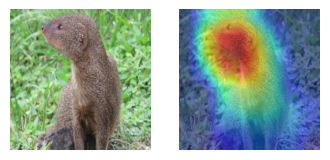

In [34]:
# exp
transform_1 = v2.Compose([
    v2.Resize([256, 256]),
    v2.ToDtype(torch.float, scale=True),
])
transform_2 = v2.Compose([
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_1 = transform_1(o_img)
img_2 = transform_2(img_1).unsqueeze(0)
img_2.to(device)

target_layer = model.module.layer4[-1].conv3

sgc = SmoothGradCAMpp(
    model,
    target_layer,
    nsamples=30,
    stdev_spread=0.2
)

cam_map = sgc(img_2, label)

# 可視化
plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))

plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(img_1.permute(1,2,0))
plt.imshow(cam_map, cmap='jet', alpha=0.5, vmin=0, vmax=1)